### Makemore Part 3: MLP with Optimizations

#### Optimize Initial Loss

https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4&t=259s

A naive way to initialize a network is to randomly assign the probability of one character
following another. This can lead to a high initial loss and then once the network starts to
train there will be a dramatic drop.

A better way to do this intiialization would be to assign the probabilty of one character
following another would be to assign them all a uniform likelihood. For instance, for our 27
characters, each character will start off with a 1/27 probability.

The effect this has on the neural network is that the network spends more time optimizing the
network rather than squashing the weights down to a point at which loss optimization can begin

#### Fixing Saturated `tanh`

https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4&t=779s

To understand that we have a saturated `tanh`, meaning the hidden layer is saturated, we can
plot the histogram of hidden layer activation values that represent the hidden layer.

```python
h_pre_activations = embeddings @ W1 + b1 # hidden layer
h = torch.tanh(h_pre_activations) # activation of hidden layer
```

![Histogram of Hidden Layer Values](images/saturated_tanh_hidden_layer_histogram.png)

To the beginner this histogram doesn't carry much meaning. To an experience engineer or researcher
this histogram presents a problem for the training of the network. 

The behavior of `tanh(x)` is a squeezing function that brings value between `-1` and `1`. 

![tanh function graph](images/tanh_function.png)

This might seem fine but if we look at the implementation of the backward pass of `tanh`, we can 
see that the derivative of `tanh(x)` is `1 - tanh(x)^2`. Therefore, the derivative of `tanh(x)` is
very small when `tanh(x)` is close to `1` or `-1`. So when the gradient update happens,
`self.grad += (1 - t**2) * out.grad`, the gradient effectively vanishes when values are close to
`1` or `-1`. The closer the derivative value of `tanh(x)` is to `0`, the gradient will effectively
pass through to the next layer of the network. So the change in the gradient is proportional to
change that occurs at `(1 - t**2)`.

To visualize how many nuerons are saturated, we can look at the graph that depicts how many neurons
have a value that will make the gradient vanish, values close to `-1` or `1`, and how many values
will make some proportion of the gradient continue to propagate. In the image, the amount of white
shows what proportion of values will make the gradient vanish.

![Hidden Layer Activation Values Boolean Tensor Graph](images/hidden_layer_activation_values_boolean_tensor.png)

Something to look for in graphs like this, is a single column that is all white. This is called a
"dead neuron" meaning that the gradient will never propagate through the neuron and the neuron
will never enter the activation area of the `tanh` function.

This behavior of `tanh` is not unique amongst activation functions. Other activation functions
such as `sigmoid`, `leaky ReLU`, `Maxout`, `ReLU` and `ELU` can have the same dangers due to
their function behavior. This can be seen by looking at their graphs.

After introducing some entropy to the initialization of the network, we can see that the network
is able to better produce neurons that will activate the `tanh` function.

```python
# Entropy introduced on the initialization of the network
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn((n_hidden,),                     generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn((vocab_size,),                   generator=g) * 0
```

![Hidden Layer Activation Values Boolean Tensor With Entropy](images/hidden_layer_activation_values_boolean_tensor_updated.png)

This will positively impact the performance of the network.

### Calculating The Initial Scale: "Kaiming Init"

The paper [Delving Deep into Rectifiers: Surpassing Human-level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)
is a good resource for learning about initializing neural networks. The
paper studies other activation functions but it is a good analysis
of how to reason about initialization.

[PyTorch `torch.nn.init.kaiming_normal`](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_)

### Batch Normailzation

Batch Normalization is a modern innovation that makes the initiailization
techniques of neural networks not as important as they were before. Batch 
Norm enabled the training of deep neural networks reliably and it "just"
worked.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Rethinking "Batch" in BatchNorm](https://arxiv.org/abs/2105.07576)


[TODO](https://youtu.be/P6sfmUTpUmc?t=2475)



In [81]:
import torch
import torch.nn.functional as F
import random
import math
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [65]:
# read in all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [66]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [67]:
block_size = 3 # context length: how many characters do we take to predict the next one?

In [68]:
# build the dataset
def build_dataset(words, label=''):
  X, Y = [], [] # inputs, labels
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append (rolling window of context)
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(label, X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1], label='train')
X_val, Y_val = build_dataset(words[n1:n2], label='validation')
X_test, Y_test = build_dataset(words[n2:], label='test')

train torch.Size([182625, 3]) torch.Size([182625])
validation torch.Size([22655, 3]) torch.Size([22655])
test torch.Size([22866, 3]) torch.Size([22866])


In [83]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / ((n_embd * block_size) ** 0.5))
b1 = torch.randn((n_hidden,),                     generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn((vocab_size,),                   generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


tensor(0.0059) tensor(0.9999)
tensor(-0.0018) tensor(1.0034)


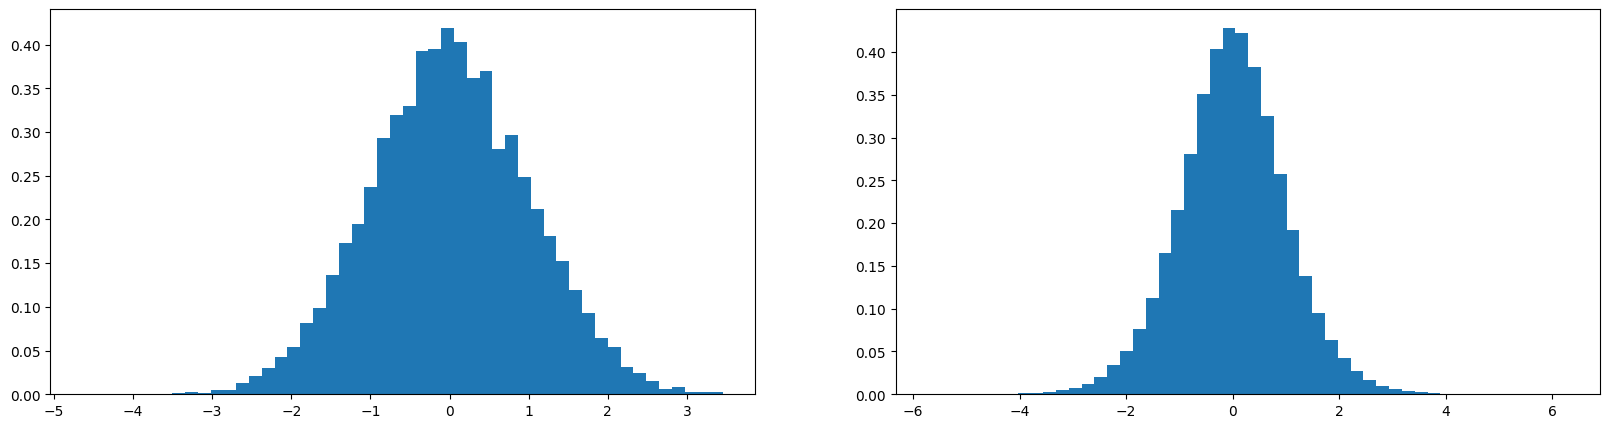

In [84]:
x = torch.randn((1000, 10), generator=g)
w = torch.randn((10, 200), generator=g) / math.sqrt(10)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [85]:
# optimzation
max_steps = 200_000
batch_size = 32
losses = []
steps = []
for i in range(max_steps):
    # batch construction
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embeded the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
    h_pre_activations = emb_cat @ W1 + b1 # hidden layer
    h = torch.tanh(h_pre_activations) # activation of hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())
    steps.append(i)

      0/ 200000: 3.3201
  10000/ 200000: 2.7599
  20000/ 200000: 2.5732
  30000/ 200000: 2.2088
  40000/ 200000: 1.9024
  50000/ 200000: 1.7802
  60000/ 200000: 1.9016
  70000/ 200000: 1.7913
  80000/ 200000: 2.0024
  90000/ 200000: 2.2631
 100000/ 200000: 2.0088
 110000/ 200000: 2.4239
 120000/ 200000: 2.2861
 130000/ 200000: 2.1693
 140000/ 200000: 2.0803
 150000/ 200000: 1.8934
 160000/ 200000: 1.7816
 170000/ 200000: 2.0157
 180000/ 200000: 2.1508
 190000/ 200000: 2.0679


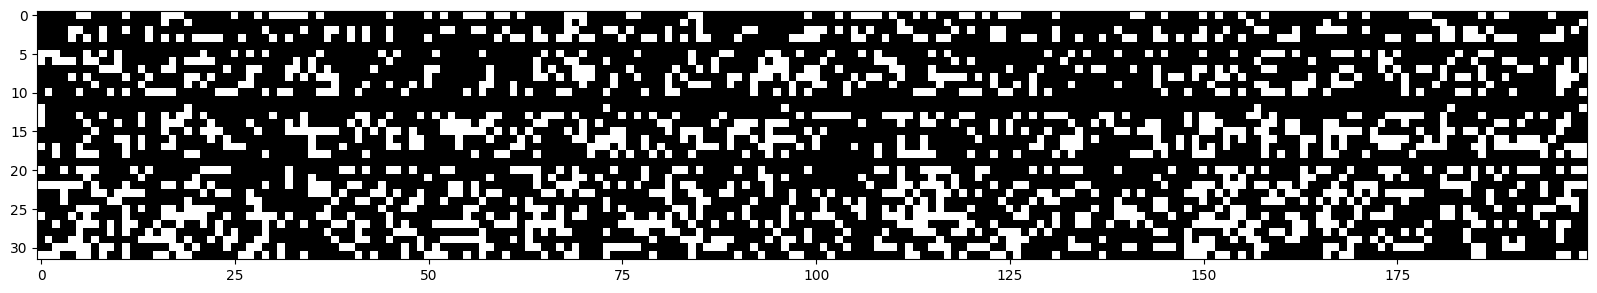

In [86]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

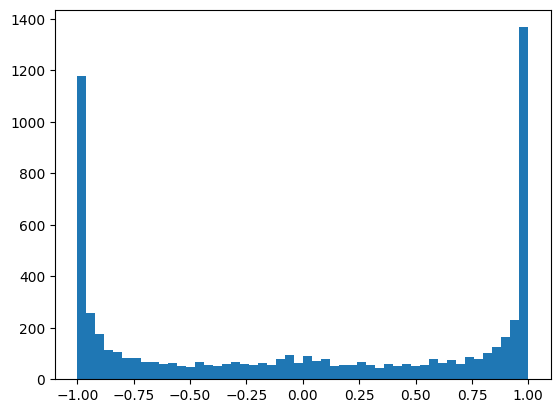

In [87]:
plt.hist(h.view(-1).tolist(), 50);

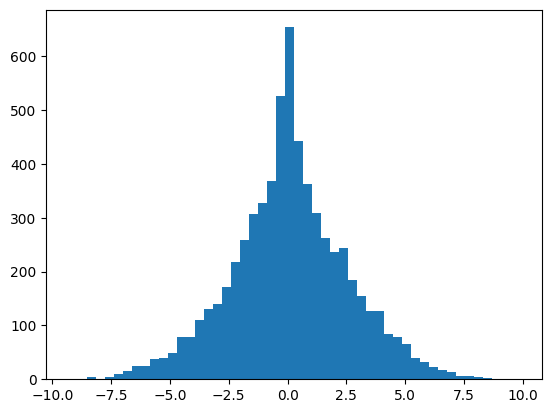

In [88]:
plt.hist(h_pre_activations.view(-1).tolist(), 50);

In [89]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [90]:
# 4 dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

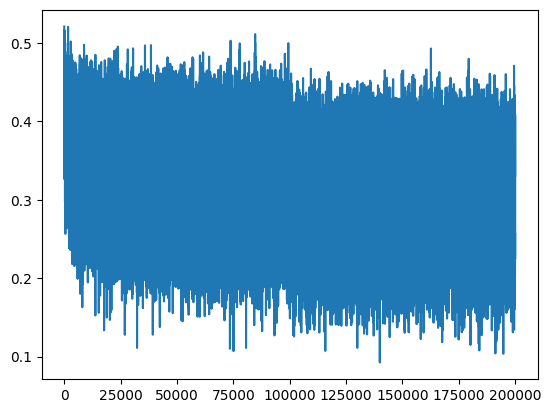

In [91]:
plt.plot(steps, losses)

In [92]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    # setup
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]

    # forward pass
    emb = C[x] # (N, block_size, n_embd)
    emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size, n_embd)
    h = torch.tanh(emb_cat @ W1 + b1) # (N, hidden_size)
    logits = h @ W2 + b2 # (N, vocab_size)

    # eval
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.038789987564087
val 2.1067955493927


In [22]:
# Sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all '...'
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amille.
khy.
mili.
taty.
skanden.
jazonen.
den.
art.
kaqui.
nextara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearyn.
kai.
